In [2]:
from math import atan, degrees, radians
import matplotlib.pyplot as plt
import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
def load_data(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        with h5py.File(f'records/record{record_num}/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def find_R_peaks(signal, channel=0, sample_freq=500, to_filter=False, seq_len=-1, check_streak=7):
    # Проблема такого метода: разная ориентация по ЭОС

    if seq_len == -1:
        channeled_signal = signal[channel]
    else:
        channeled_signal = signal[channel][0:seq_len]


    if to_filter:
        channeled_signal = nk.ecg_clean(channeled_signal, sampling_rate=sample_freq)
    
    streak = 0
    p_peaks = []
    heart_rate = []
    for i in range(1, len(channeled_signal)):
        if atan((abs(channeled_signal[i] - channeled_signal[i-1]))*sample_freq) > radians(85):
            streak = streak + 1
            if channeled_signal[i] - channeled_signal[i-1] < 0:
                if streak > check_streak:
                    p_peaks.append(i)
                    if len(p_peaks) > 1:
                        heart_rate.append(p_peaks[len(p_peaks) - 1] - p_peaks[len(p_peaks) - 2])

                streak = 0
        else:
            if streak > check_streak:
                p_peaks.append(i)
                if len(p_peaks) > 1:
                    heart_rate.append(p_peaks[len(p_peaks) - 1] - p_peaks[len(p_peaks) - 2])

            streak = 0

    
    return p_peaks, heart_rate

def visualize_channel_with_peaks(signal, peaks, sample_freq=500, channel=0, to_filter=False, seq_len=-1):
    ecg_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    plt.rcParams['figure.figsize'] = [14, 4]

    plt.title(ecg_order[channel])

    signal_ = signal[channel]

    if to_filter:
        signal_ = nk.ecg_clean(signal_, sampling_rate=sample_freq)

    if seq_len == -1:
        plt.plot(signal_)
    else:
        plt.plot(signal_[0:seq_len])

    plt.title((f'Отведение {ecg_order[channel]}'))

    for peak in peaks:
        plt.axvline(peak, color='red', alpha=0.2)

    plt.show()



In [64]:
signals, labels = load_data()

Data loaded successfully.
          Health    number:     6
          Diseased  number:     4




22;23


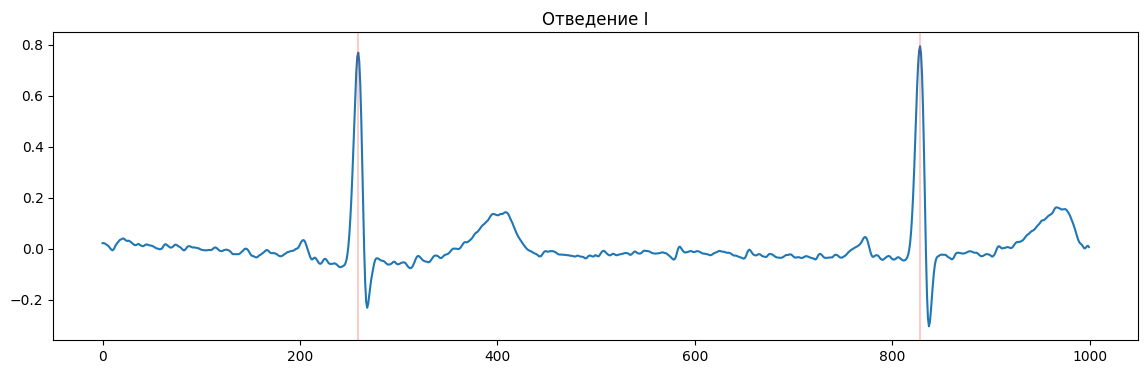

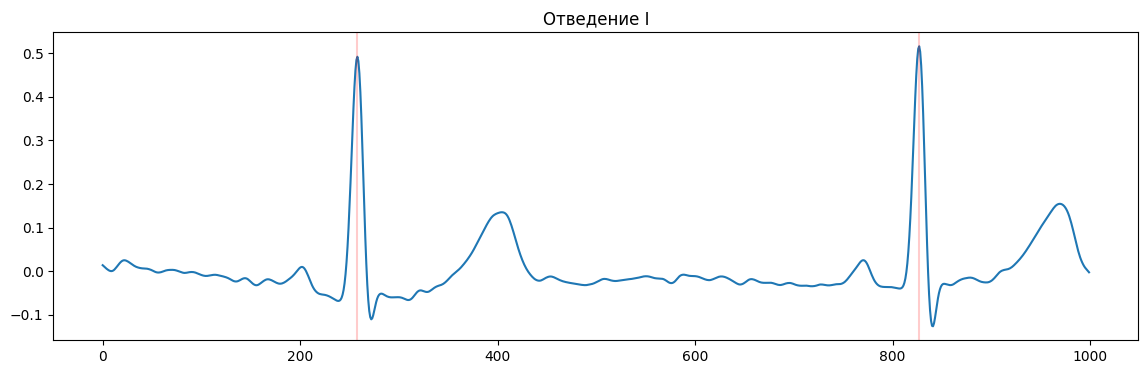

1


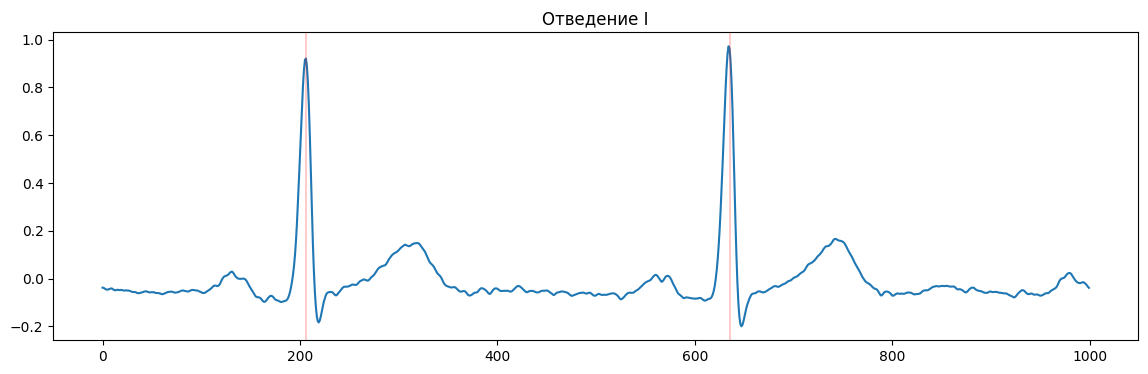

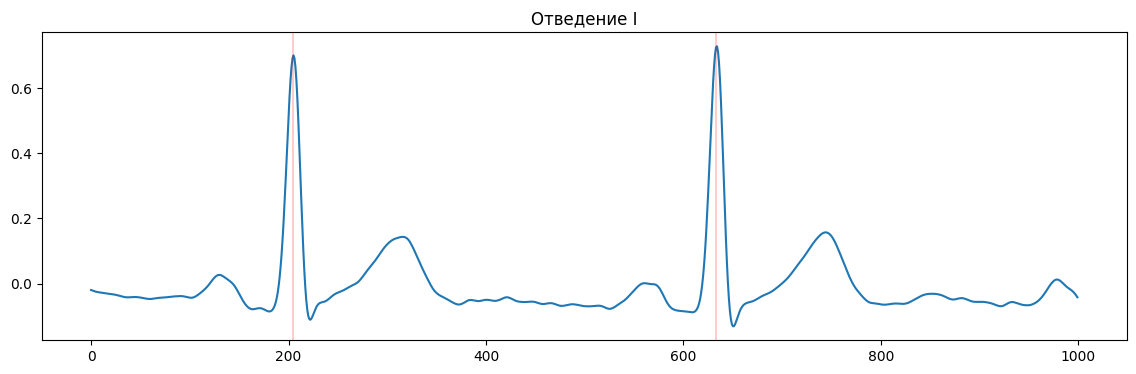

1


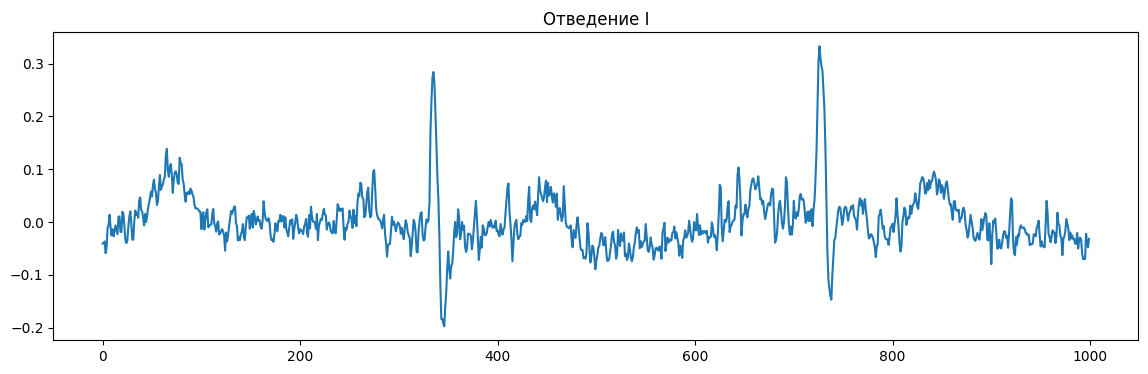

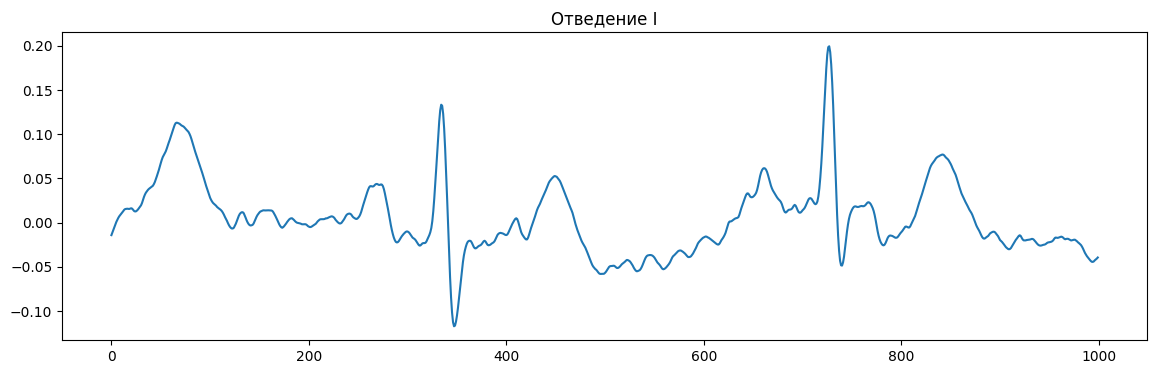

23


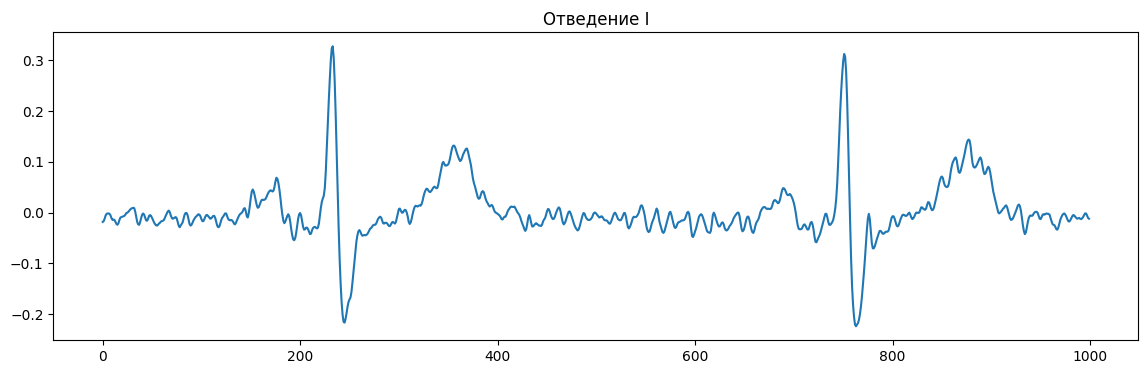

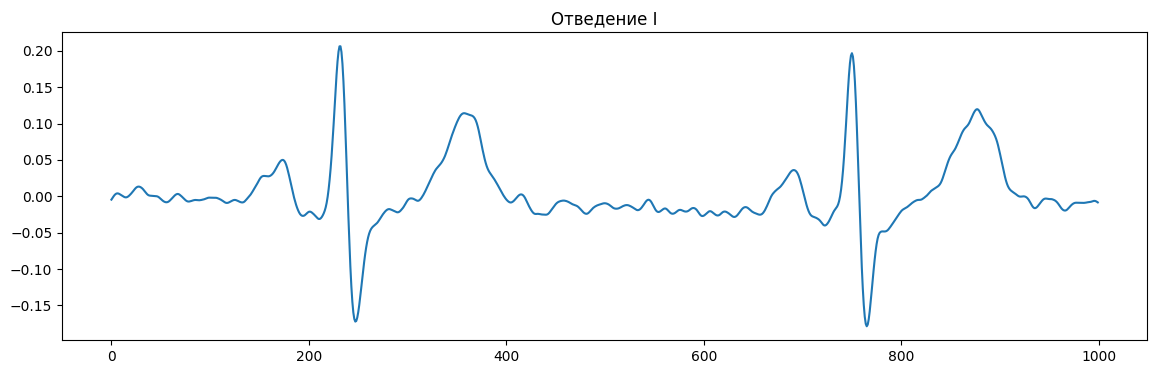

146


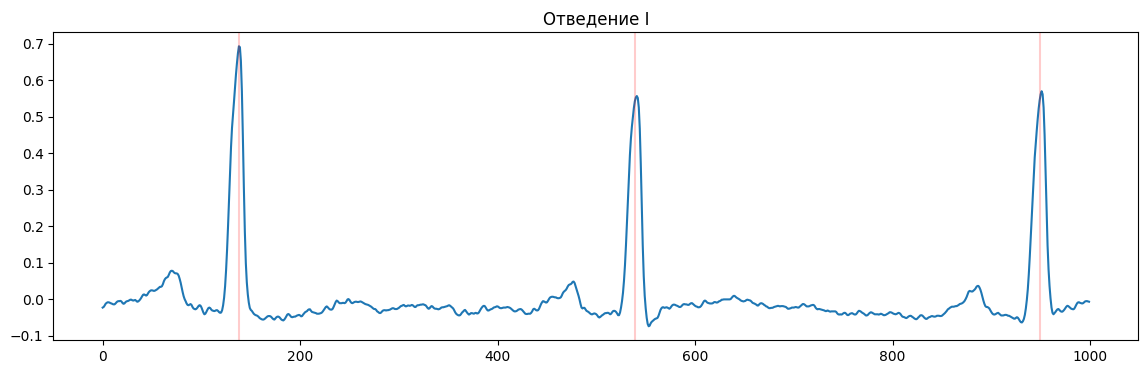

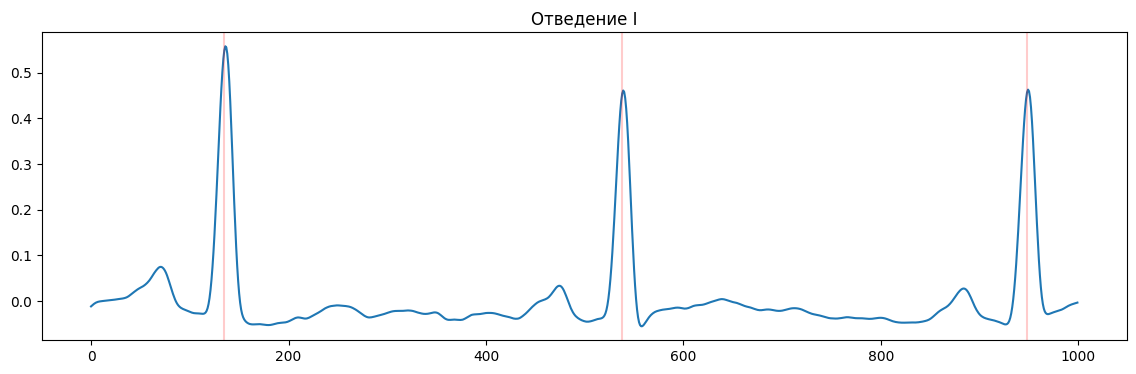

1


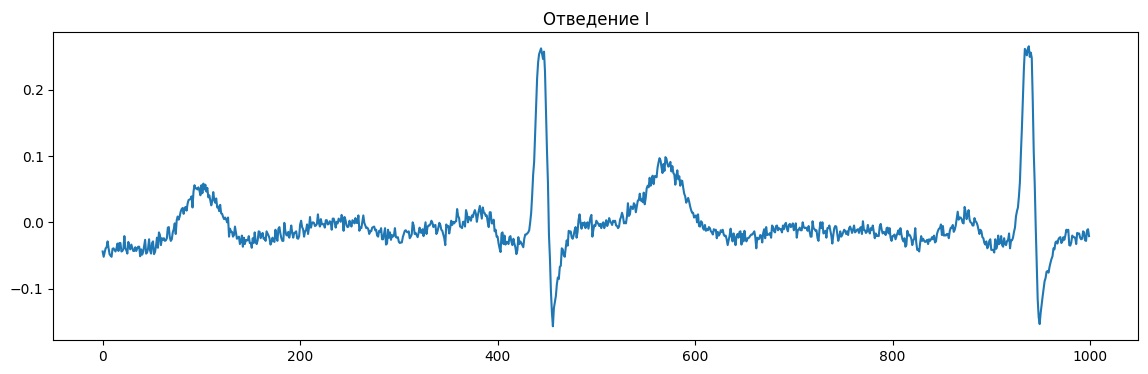

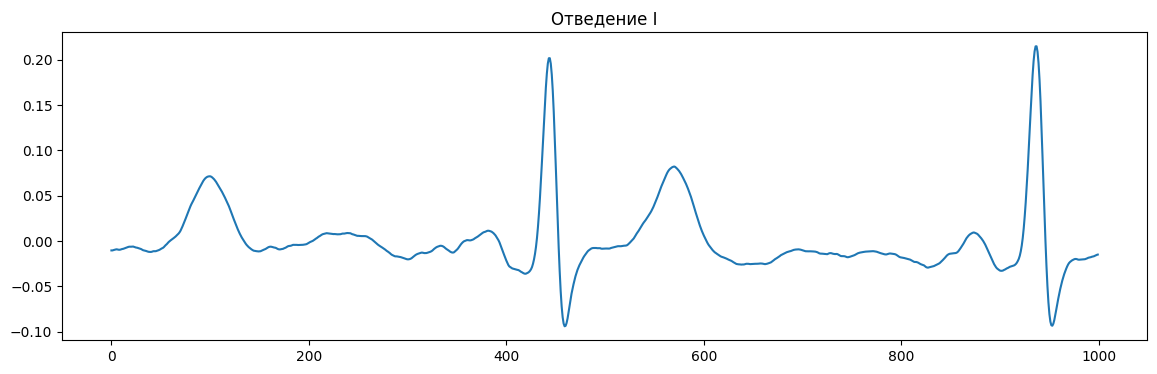

106


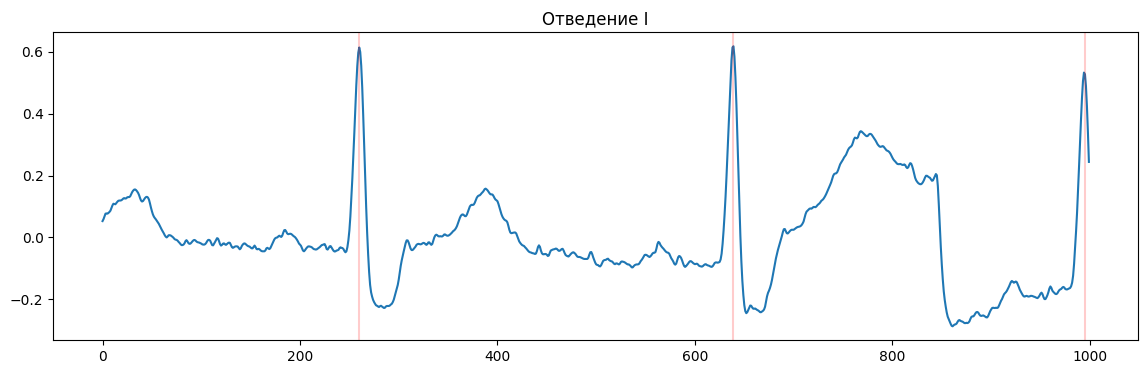

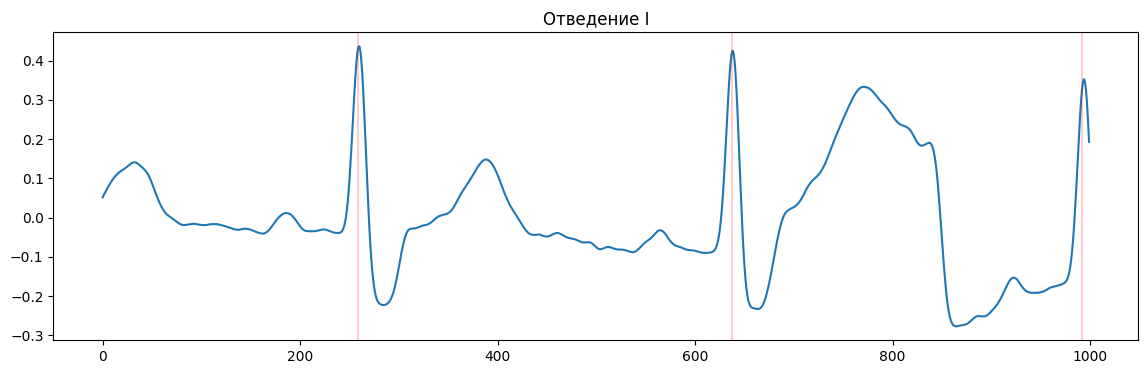

1


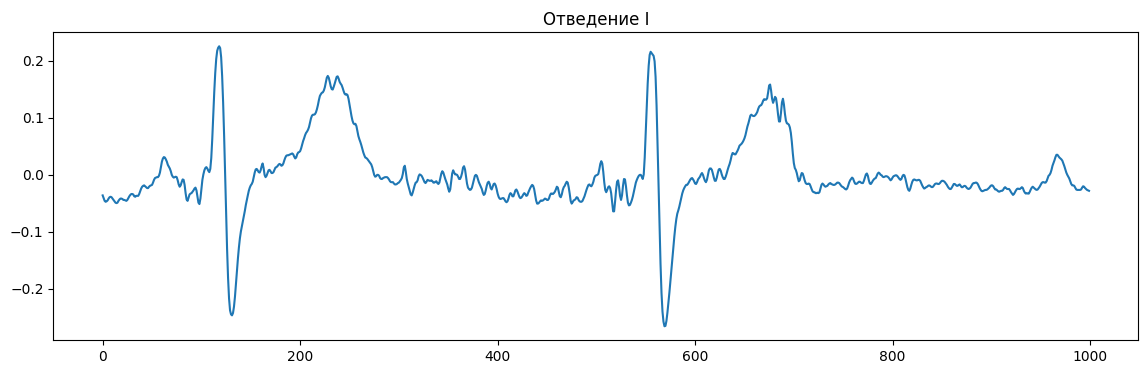

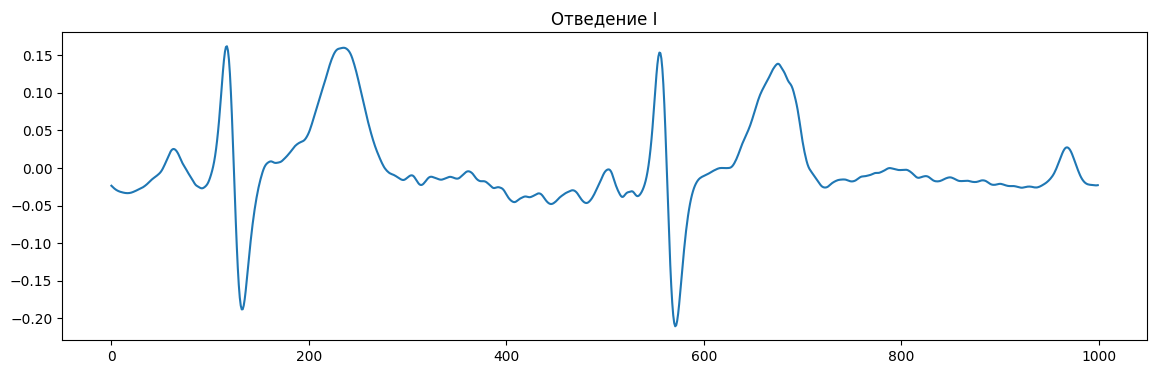

1


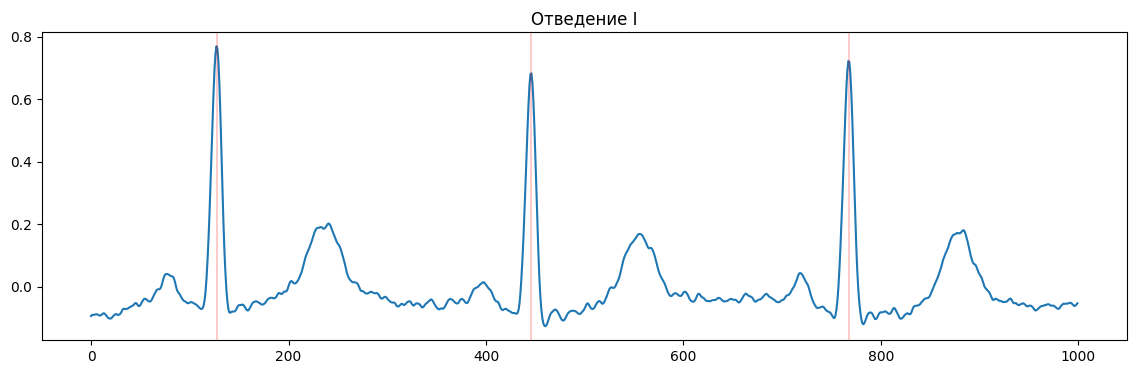

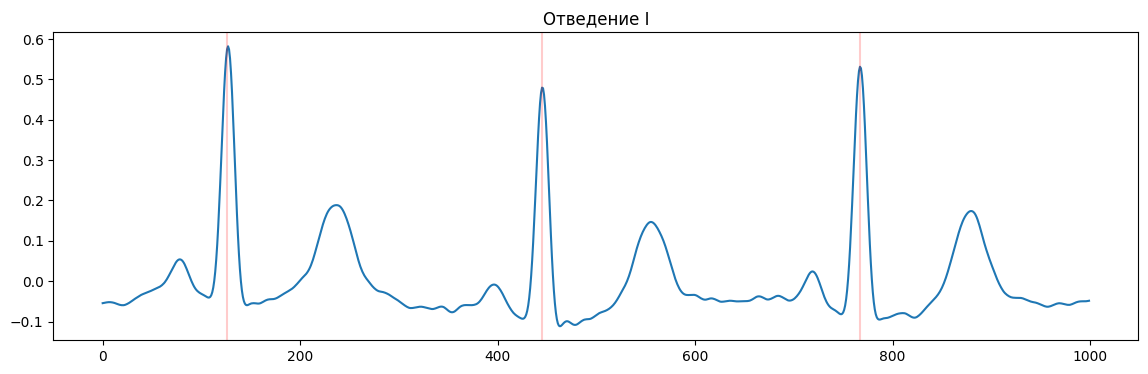

1


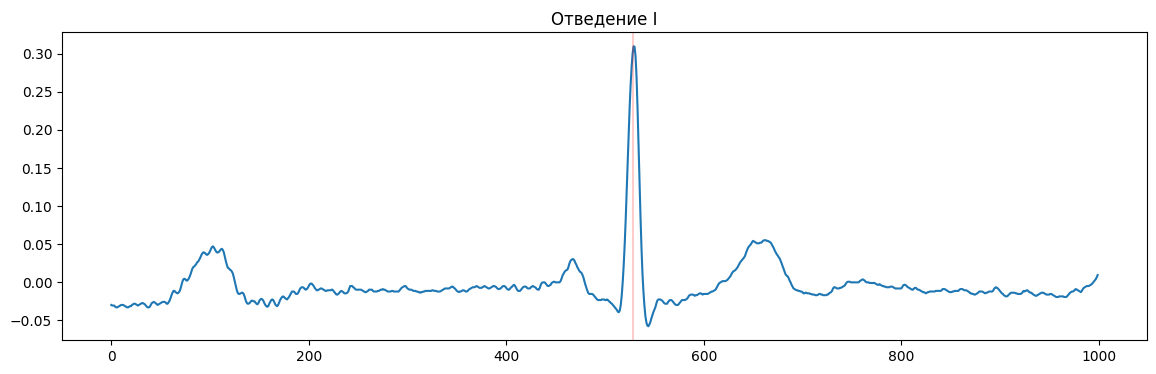

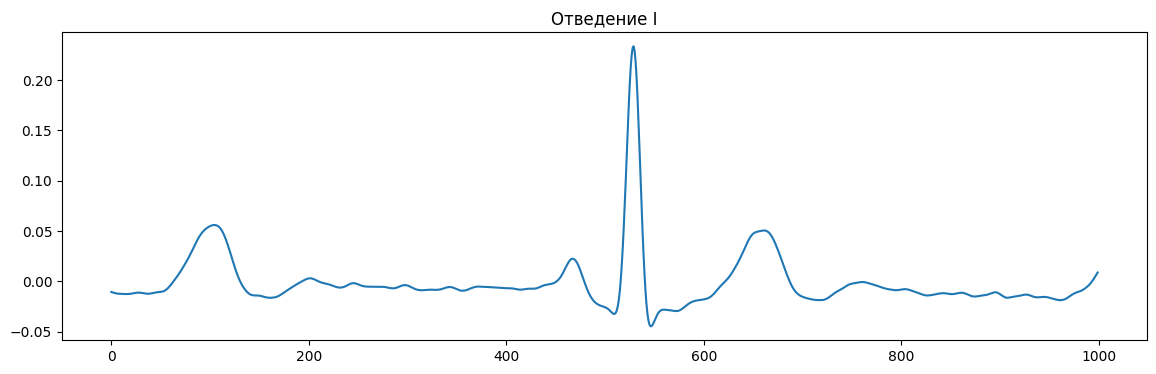

In [66]:
seq_len = 1000

for i in range(len(signals)):
    print(labels[i])
    
    p_peaks_0, heart_rate_0 = find_R_peaks(signals[i], seq_len=seq_len)
    visualize_channel_with_peaks(signals[i], p_peaks_0, seq_len=seq_len)

    p_peaks_0, heart_rate_0 = find_R_peaks(signals[i], to_filter=True, seq_len=seq_len)
    visualize_channel_with_peaks(signals[i], p_peaks_0, to_filter=True, seq_len=seq_len)

In [67]:
def BIC(x, y_true, k_max):
    n = len(y_true)
    b = []

    for k in range(1, k_max + 1):
        coefs_trended = np.polyfit(x, y_true, k)
        y_pred = np.polyval(coefs_trended, x)

        eps = np.sum((y_true - y_pred) * (y_true - y_pred)) / n

        b.append(n*np.log(eps) + k*np.log(n))

    plt.plot(np.arange(1, k_max + 1, 1), b, 'r.-')

    plt.plot([1, k_max], [min(b), min(b)], 'b-', alpha=0.5)
    plt.plot([np.argmin(b) + 1, np.argmin(b) + 1], [min(b), max(b)], 'b-', alpha=0.5)

    print(np.argmin(b))
    plt.show()

    return np.argmin(b)

16


C:\Users\Админ\AppData\Local\Temp\ipykernel_53300\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_53300\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_53300\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_53300\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_53300\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_53300\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykernel_53300\2603242694.py:6: RankWarning: Polyfit may be poorly conditioned
  k1 = BIC(x1, y1, 30)
C:\Users\Админ\AppData\Local\Temp\ipykern

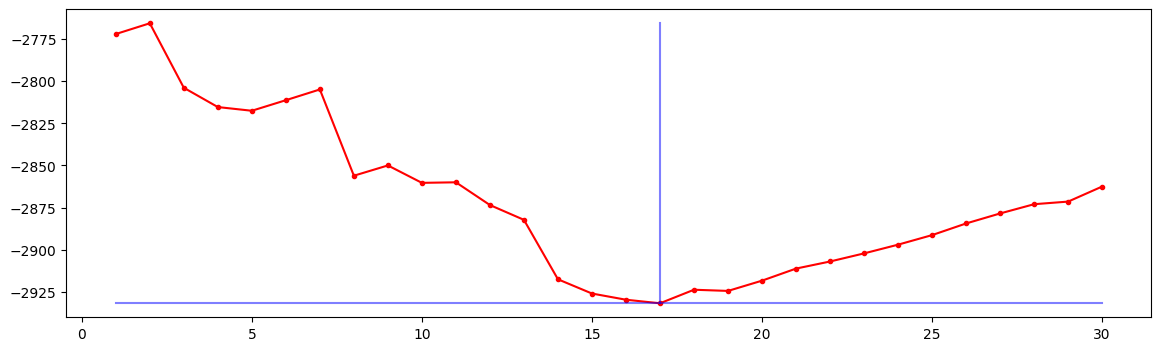

In [88]:
y1 = signals[6][0][0:600]
y1 = [float(i) for i in y1]

x1 = np.linspace(0, 1, len(y1))

k1 = BIC(x1, y1, 30)

In [103]:
def visualize_detrended_data(signals, n, channel, start, end, k1):
    y1 = signals[n][channel][start:end]
    y1 = [float(i) for i in y1]
    x1 = np.linspace(0, 1, len(y1))

    coefs_trended1 = np.polyfit(x1, y1, k1)
    y_pred1 = np.polyval(coefs_trended1, x1)

    plt.plot(x1, y1, color='blue', alpha=0.5, label='Original')
    plt.plot(x1, y1 - y_pred1, color='red', alpha=0.5, label='Detrended')
    plt.axhline(0, label='Izoline (0)')
    plt.legend()
    plt.show()

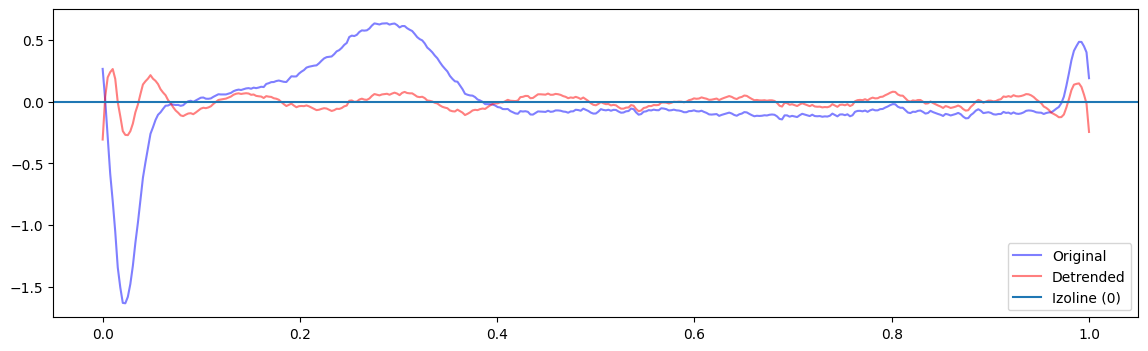

In [117]:
visualize_detrended_data(signals, 2, 7, 334, 727, 16)